# ECE 313 Spring 2024: Lab3
## More D.T. LTI Filtering

Prof. Jon Tamir

TA: Asad Aali

These labs were developed by Prof. Babak Ayazifar for EE 120 at UC Berkeley

v1 - Spring 2019: Dominic Carrano, Sukrit Arora, and Babak Ayazifar  
v2 - Fall 2019: Dominic Carrano

v3 - Fall 2021: Jon Tamir, and Shaohui Liu

In [59]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Q1: Data Smoothing

In the previous problem set, we saw that the edge detector was good at finding edges in piece-wise constant signals, but further amplified a noise signal.

One of the most common uses of LTI filters is in data smoothing. The applications are numerous, ranging from noise reduction, to extracting trends from complex data, to interpolation, and more. In this question, we'll explore the simplest, yet perhaps most widely used, data smoothing method in a few of these application spaces: a moving average filter.

## Q1a: Noise Reduction

The *simple* moving average filter is specified in terms of a single integer parameter, $L$, which represents the length of the filter. The filter takes the average of the $L$ points before, and including, the current point of a signal, outputting that average. Formally, the filter's impulse response is:

$$h_{SMA}[n] = \frac{\delta[n] + \delta[n - 1]\ +\ ...\ +\ \delta[n - (L - 1)]}{L}$$

Note that the definition we'll use here is for the *causal* moving average filter: the output at any point in time is only computed as an average of the current and previous signal values. You probably recognize the impulse response - it's just a length $L$ rect normalized to sum to 1. 

The subscript "SMA" in the impulse response definition stands for *Simple Moving Average*, meaning all points are given equal weight in computing the average. This distinguishes the filter from more elaborate moving averages, such as the *Exponential Moving Average* (EMA) which gives more recent data points a higher weight. You'll get a chance to explore the EMA later in this Lab. We encourage you to check out reference [1] for more on the theory behind the use of moving average filters for noise reduction if interested.

### Your Job: Signal Generation

In the cell below, do the following:
- Generate the time indices $\{0, 1, ..., 999, 1000\}$.
- Generate the signal $x[n] = e^{n / 300}$ over these time indices.
- Append 500 zeros onto the end of $x$, and extend your time indices to account for these extra data points. That is, your time indices should now be $\{0, 1, ..., 1000, 1001, ..., 1500\}$.
- Generate noise $z$ of the same dimensions as $x$, by using [np.random.normal](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) with the parameters `loc=0, scale=4, size=np.shape(x)`. 
    - As a reminder, `np.shape(x)` returns how many entries `x` has along each dimension (here, our signal is 1D, so `np.shape` just returns the number of entries), which we can pass into a numpy function to easily generate numpy arrays (i.e. signals) of the same size as some other numpy array. 
- Create the noisy signal $y = x + z$.
- On the same 16x4 figure, plot $x$ and $y$. Using [plt.legend](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.legend.html), label $x$ as "True Signal" and $y$ as "Noisy Signal". **Make sure you use `plt.plot`, *not* `plt.stem`, for plotting.** You should use the time indices you generated as the first argument to `plt.plot`.

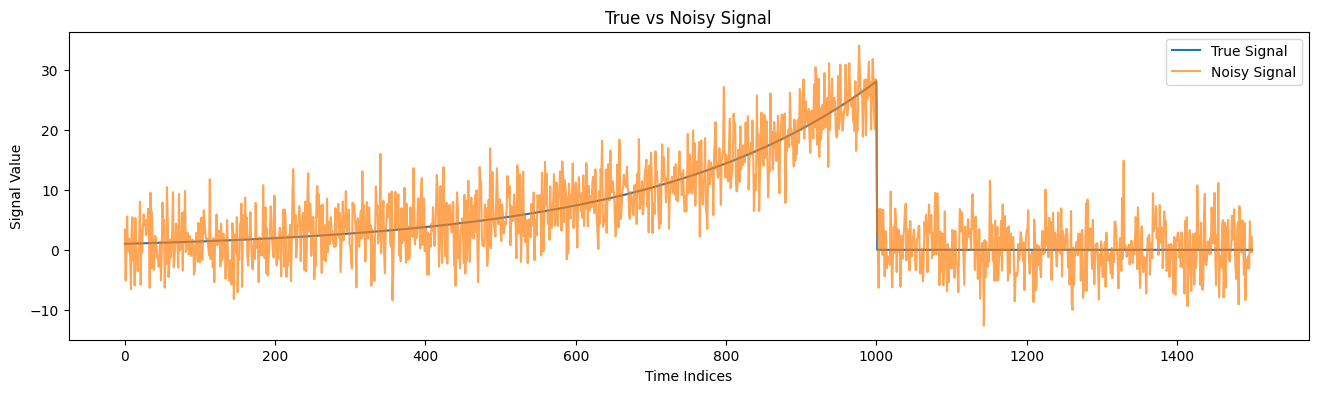

In [60]:
# TODO your code here

import numpy as np
import matplotlib.pyplot as plt

time_indices = np.arange(0, 1501)
x = np.exp(time_indices[:1001] / 300)
x = np.append(x, np.zeros(500))
z = np.random.normal(loc=0, scale=4, size=np.shape(x))
y = x + z
plt.figure(figsize=(16, 4))
plt.plot(time_indices, x, label="True Signal")
plt.plot(time_indices, y, label="Noisy Signal", alpha=0.7)
plt.legend()
plt.xlabel("Time Indices")
plt.ylabel("Signal Value")
plt.title("True vs Noisy Signal")
plt.show()


If your code is correct, you should see an exponential that rises in amplitude from 0 to ~30 over the course of the first 1000 samples followed by 500 zeros. Overlayed on top of it, you'll see a signal that jumps up and down, **but, on average, follows the sample amplitude as the original signal.**

### Your Job: Signal Denoising

Now that we've got a (not so) nice and noisy signal, let's try to denoise it with a moving average. Intuitively, since the noisy signal follows, on average, the original one, we should be able to reduce the noise a bit by averaging adjacent data points. The hard part, and a great example of an engineering tradeoff, is figuring out the right number of points to average at a time. 

The array `filt_sizes` containing the different sizes (the parameter $L$ from above) we'll try out has been defined for you. In the cell below:
- Create a 20x35 figure. We will be creating a column of subplots, one for each filter length (note `len(filt_sizes)` is 7).
- For each filter size in `filt_sizes`,
    - Create a simple moving average filter, $h$, of that size.
        - Don't bother doing any zero padding of $h$. Instead, just construct the filter for all points where it is nonzero.
    - Compute $\hat{x} = y * h$, where $y$ is the noisy growing exponential signal you created above. Naming this variable `x_hat` in your code is fine. **Use "full" as the convolution mode.** If we don't use "full", the filter will be non-causal due to the way we defined the impulse response. 
    - On a new subplot (that is, for each different moving average filter, we're using a separate subplot):
        - Plot $x$, the original (noiseless) signal. You can use the variable $n$ from above for the time indices.
        - Plot $\hat{x}$, the moving averaged version of $y$ you computed in the current loop iteration. 
            - Since we didn't use "same" for the convolution (motivated by the desire to have a causal filter), we need an expanded set of time indices to plot with. 
            - As a freebie, the code for this is `n_aug = np.concatenate((n, np.arange(n[-1], n[-1] + (len(x_hat) - len(n)))))`. This just adds on the extra indices to the end of the existing ones based on how much the convolution stretches the signal $x$ by.
        - Use `plt.legend` to label $x$ as "True Signal" and $\hat{x}$ as "Noisy Signal after ?-point SMA", where "?" should be replaced by the current filter size. Python's [format](https://www.digitalocean.com/community/tutorials/how-to-use-string-formatters-in-python-3) function may be of use here.

**Note:** $\hat{x}$ and $h$ change with each new filter size; $x$ and $y$ do not.

**Hint 1:** It will be most informative to display our subplots as a column. Thus, your call to `plt.subplot` should look something like `plt.subplot(len(filt_sizes), 1, i)`  where `i` is a variable tracking which subplot we're currently on (i.e., it starts at 1, and should increase by 1 each time we create and apply a different moving average filter).

**Hint 2:** Make sure to call `plt.show()` *after* you've created all your subplots (i.e., it should NOT be called inside a loop). You only call `plt.show()` once per figure, i.e. after you're finished generating all the subplots.

In [61]:
filt_sizes = [2, 5, 10, 20, 50, 100, 500]

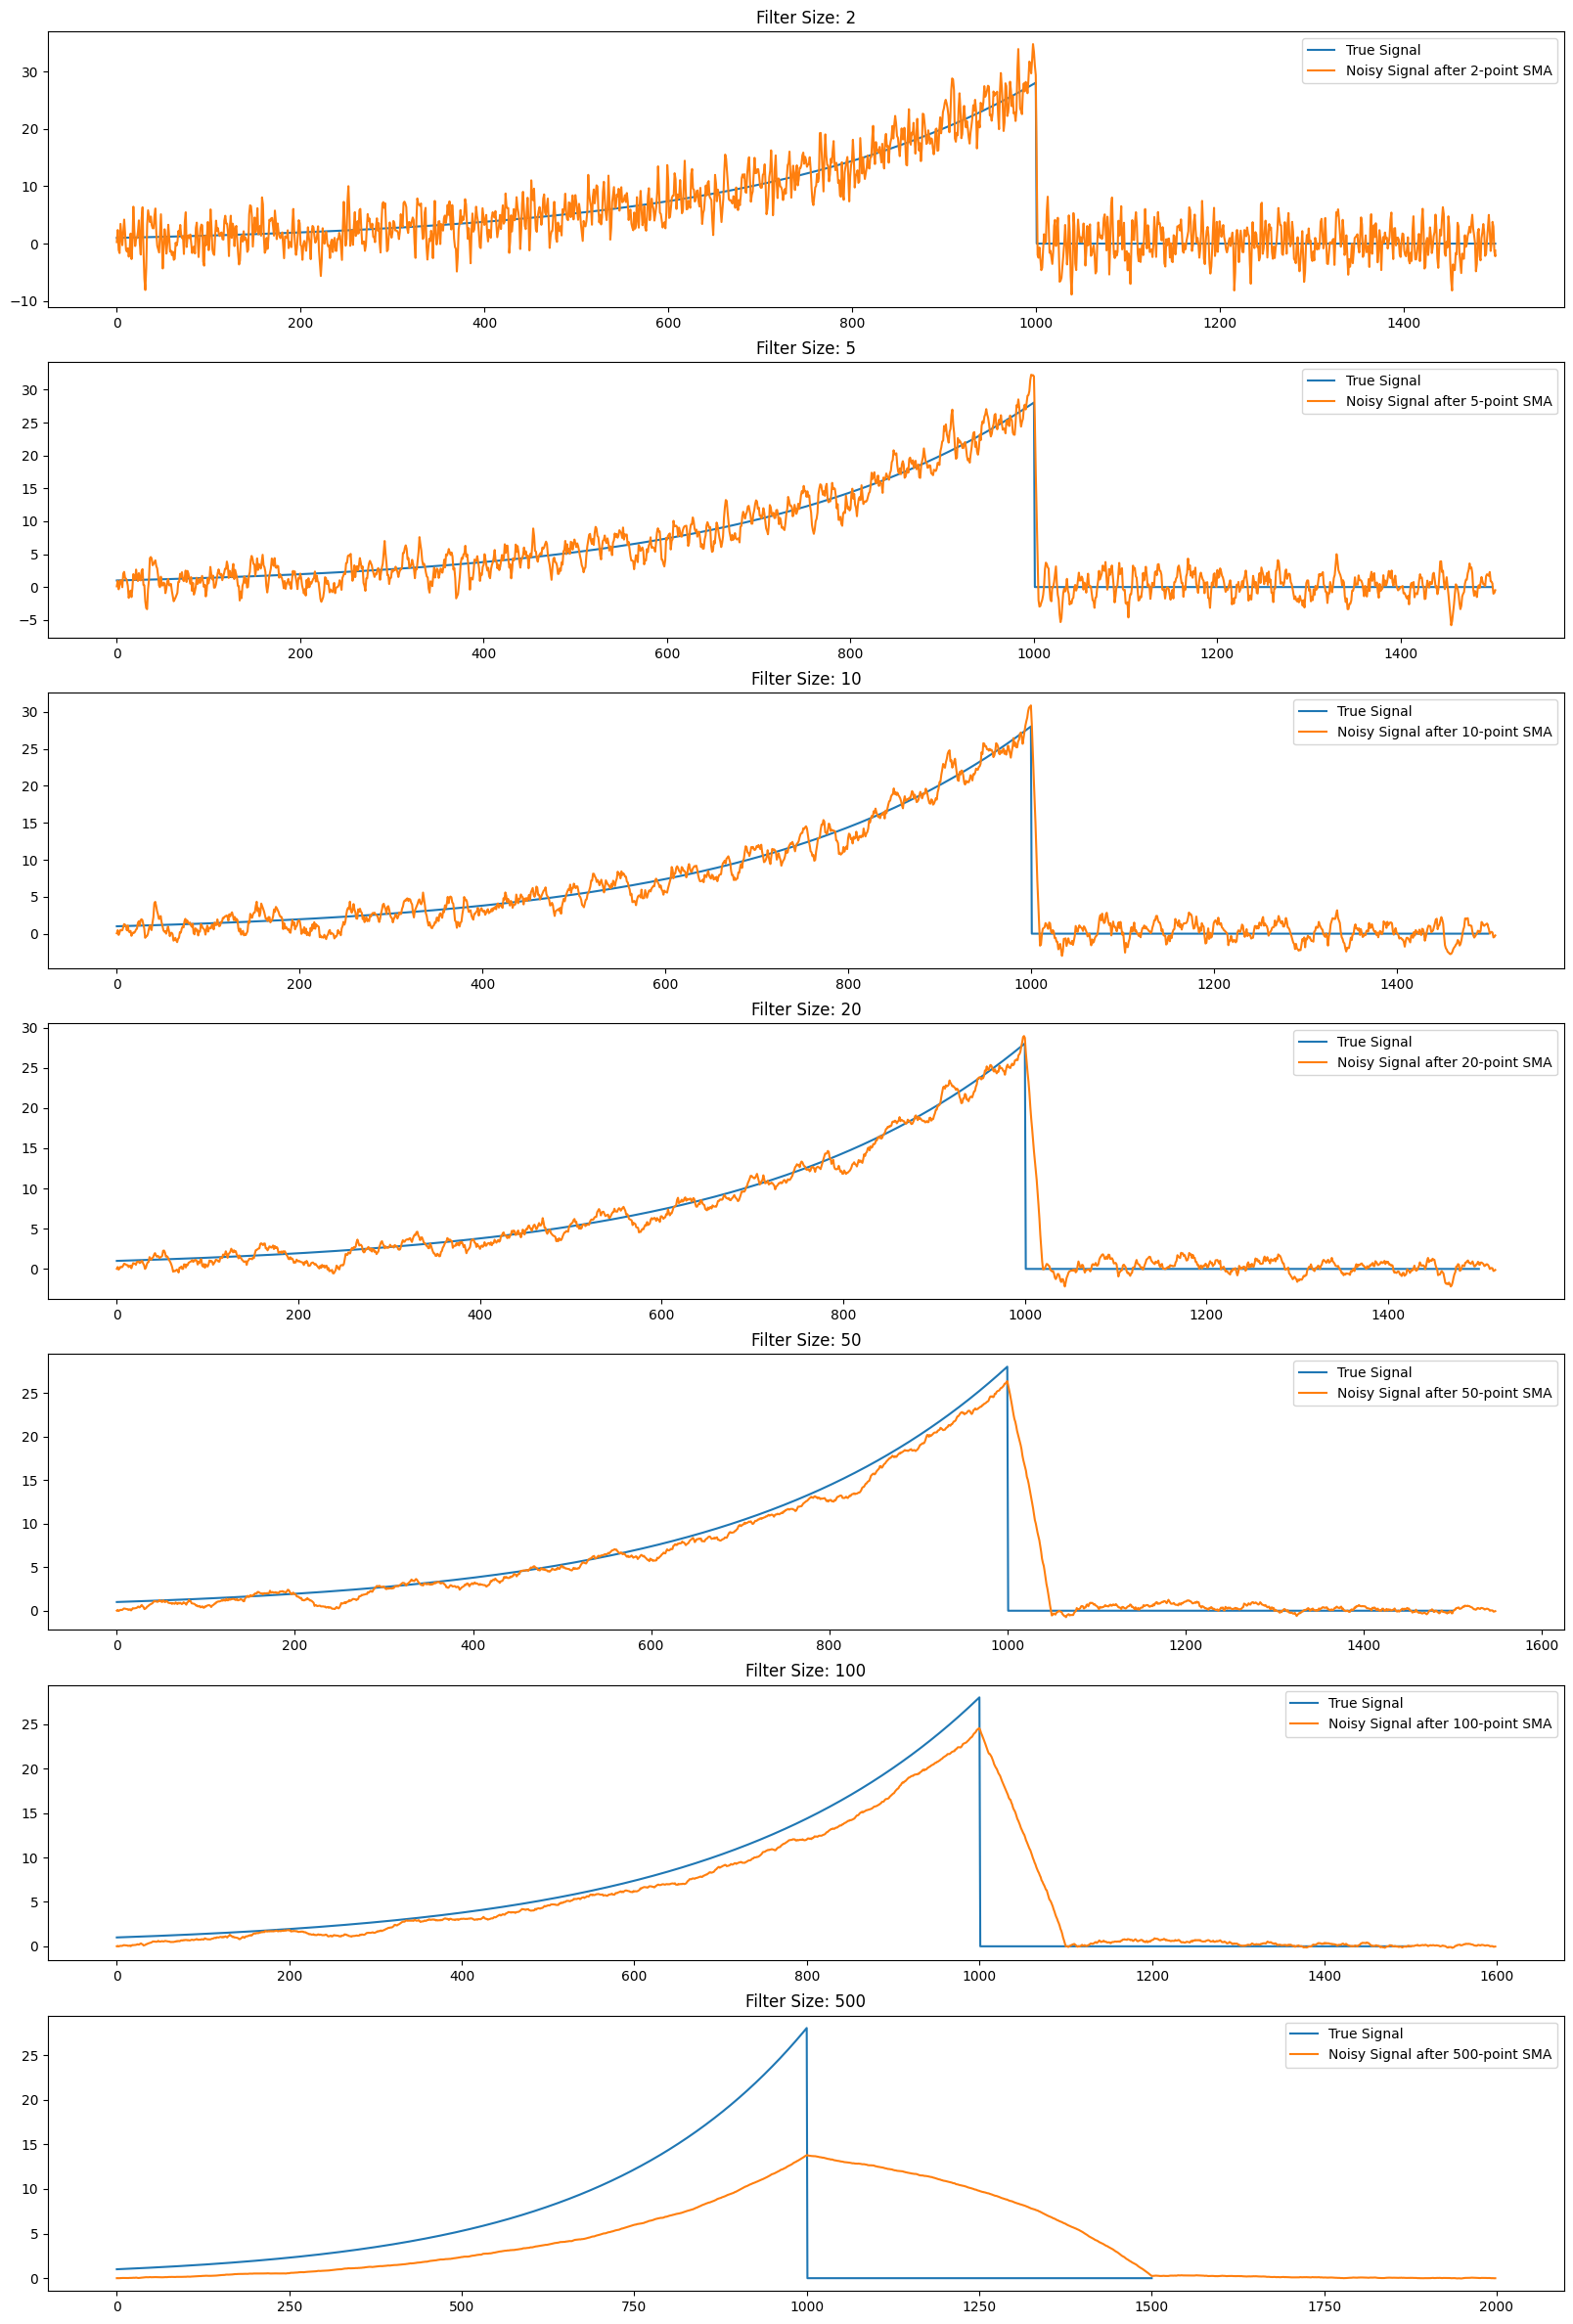

In [62]:
# TODO your code here
# TODO your code here
import numpy as np
import matplotlib.pyplot as plt

time_indices = np.arange(0, 1501)
x = np.exp(time_indices[:1001] / 300)
x = np.append(x, np.zeros(500))
z = np.random.normal(loc=0, scale=4, size=np.shape(x))
y = x + z
filt_sizes = [2, 5, 10, 20, 50, 100, 500]
plt.figure(figsize=(20, 30))
for i, L in enumerate(filt_sizes, start=1):
    h = np.ones(L) / L
    x_hat = np.convolve(y, h, mode="full")
    n_aug = np.concatenate((time_indices, np.arange(time_indices[-1], time_indices[-1] + (len(x_hat) - len(time_indices)))))
    plt.subplot(len(filt_sizes), 1, i)
    plt.plot(time_indices, x, label="True Signal")
    plt.plot(n_aug, x_hat, label=f"Noisy Signal after {L}-point SMA")
    plt.legend()
    plt.title(f"Filter Size: {L}")

plt.show()

A few sanity checks:
- In all cases, the true signal should go from 0 to 1500 and look the same.
- As we increase the filter length, the noisy signal (post-filtering) will be stretched further and further out, occupying just over 1500 points for the length 2 and length 5 filters, and about 2000 points for the length 500 filter.
- The peak of the noisy signal (post-filtering) should always line up with the true signal's peak. This is a good sanity check that the filter is causal: if it doesn't look ahead, then the filter's first encounter with the peak will be averaging the peak with the previous (positive) values, resulting in a peak in the output. After the filter sees the true signal's peak, it only sees zeros, so averaging in more and more zeros instead of the positive values on the exponential will lead to smaller and smaller output values.

### Analyzing the plots

**Q:** As we increase the filter length, do the first 400-500 points of the filtered signal get smoothed out (reducing the noise at these points) or blown up (amplifying the noise)? Ignore any scaling differences; that is, if the filtered signal looks the same as the true one except for being off by a constant scaling factor, that's fine.

<span style="color:blue">**A:** (TODO) </span>
Increasing the filter length in a simple moving average filter smooths out the first 400-500 points of the filtered signal, reducing the noise at these points.

**Q:** As we increase the filter length, what happens to our signal's sharp, high-frequency feature, the drop off from the top of the exponential back down to zero (at $n=1000$)? Is this high-frequency feature preserved, or does it get more and more distorted? Explain, based on the moving average filter, why this makes sense.

<span style="color:blue">**A:** (TODO) 
.</span>
increasing the filter length causes more distortion to the signal's sharp, high-frequency features due to the smoothing and low-pass filtering characteristics of the moving average filter. This effect leads to a loss of detail in these features as they become more blurred and less pronounced in the filtered signal.


**Q:** Putting your previous answers together, what advantage is there to using a longer moving average for noise reduction? What do we have to trade off (i.e., what disadvantage becomes more and more pronounced) in doing so?

<span style="color:blue">**A:** (TODO)  </span>

The main benefit of using a longer moving average for noise reduction is that it smoothes out the noise more efficiently, producing a signal that is cleaner. This is so that the effects of noise or random oscillations in the signal are lessened by a longer filter, which averages over a larger number of data points.

Sharp, high-frequency signal features suffer more distortion as a trade-off for this improved noise suppression. Preserving the crisp edges and rapid transitions of the original signal gets harder as the filter length gets longer. To accurately depict the dynamics and properties of the signal, these features are necessary. Furthermore, a longer filter may cause time-sensitive features to become misaligned because it adds a more noticeable delay or phase shift to the signal.

**Q:** Assuming you equally prioritize minimizing distortion of sharp, high-frequency features while still getting a reasonable amount of noise reduction, which of the following moving average filter lengths would you pick from above for denoising this specific signal? There are multiple correct answers; just be sure to justify your choice.

<span style="color:blue">**A:** (TODO) </span>

 For balancing noise reduction with minimal distortion of sharp, high-frequency features, filter lengths of 20 shoud be picked imo. Thiw length offer a good compromise between smoothing out noise and preserving the integrity of sharp transitions, such as the drop-off at n=1000, without introducing excessive blurring or distortion. Longer filters provide more noise reduction but at the cost of significantly distorting high-frequency details, while shorter filters might not adequately reduce noise. In short, length <20 can be noisy and unclear, but lengths > 20 change and lower sharp feature of signal
 

## Q2b: Extracting Trends from Data

In addition to its use in signal processing and statistics for noise reduction, the moving average filter is popular in analysis of financial data for highlighting trends in stock prices.

Here, we'll analyze one of the most common datasets in time series analysis: stock price data! Run the cell below to load it. We will be taking a look at Apple's stock data from mid 2017 to early 2019.

We got this data from Yahoo! finance. If you are interested in playing around with stock data on your own, you can click on a stock, navigate to the historical data tab, download a csv file, and use our code below to parse it. Acquiring data often plays second fiddle to all the fancy algorithms used on it despite being just as important a part of any engineering field that relies on it. However, here, we want to focus on the algorithms, not the minutiae of Yahoo! csv file formats, hence why we provide the code to read the data in.

In [63]:
# CSV hocus pocus
import csv

stock_dates = []
stock_prices  = []
with open('AAPL.csv', mode='r') as raw_data:
    csv_reader = csv.DictReader(raw_data)
    for row in csv_reader:
        data = row['Close']
        if not data == 'null':
            stock_prices.append(float(data))
            stock_dates.append(row['Date'])
stock_prices = np.array(stock_prices)

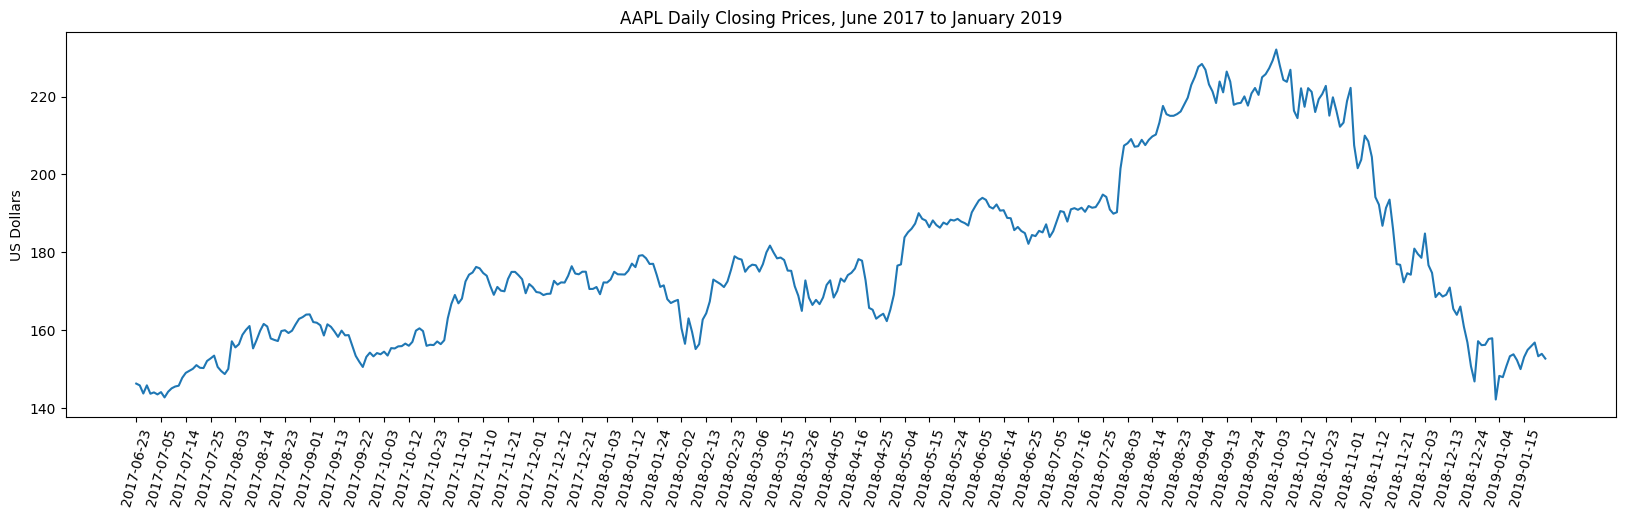

In [64]:
# 400 most recent days
start = -400
end = -1
x = np.arange(len(stock_prices[start:end]))

# Plot roughly one data point per week (x[::7]) so we can display dates 
plt.figure(figsize=(20, 5))
plt.xticks(x[::7], stock_dates[start:end:7], fontsize=10, rotation=75)
plt.plot(x, stock_prices[start:end])
plt.title("AAPL Daily Closing Prices, June 2017 to January 2019")
plt.ylabel("US Dollars")
plt.show()

### Your Task

Your job is to fill in the missing parts of the cell below to filter the noise with moving average filters of length 5, 25, and 75, and be sure to answer the question about interpreting the results below the cell. Unlike Q2a, most of the work has been done for you here.

In the cell below:
- Define the moving average impulse responses as `MA5, MA25, MA75` respectively.
    - Again, don't bother with any zero padding - just define them at their nonzero points.
- Filter your test data (`data`) with each of them using **convolution with the "same" mode**. We'll call the outputs `y5, y25`, and `y75`, respectively.

*Note:* **Here, we are *not* using causal moving averages as we did in Q2a.** The motivation in doing so is that we want the filtered signals to temporally align with the original to make the results easier to interpret. While real-time filters have to be causal, we're working in an offline setting with pre-collected data here, so causality is less important, and interpretability is more useful. These properties are some of the tradeoffs involved in how data processing is done.

Plotting code has been provided for you. To generate the results, simply run the cell after adding your own code.

In [65]:
data = stock_prices[start:end]

In [66]:
## TODO your impulse response definitions here
MA5 = np.ones(5)/5
MA25 = np.ones(25)/25
MA75 = np.ones(75)/75


In [67]:
## TODO your filtering code here
y5 = np.convolve(data, MA5, mode = 'same')
y25 = np.convolve(data, MA25, mode = 'same')
y75 = np.convolve(data, MA75, mode = 'same')


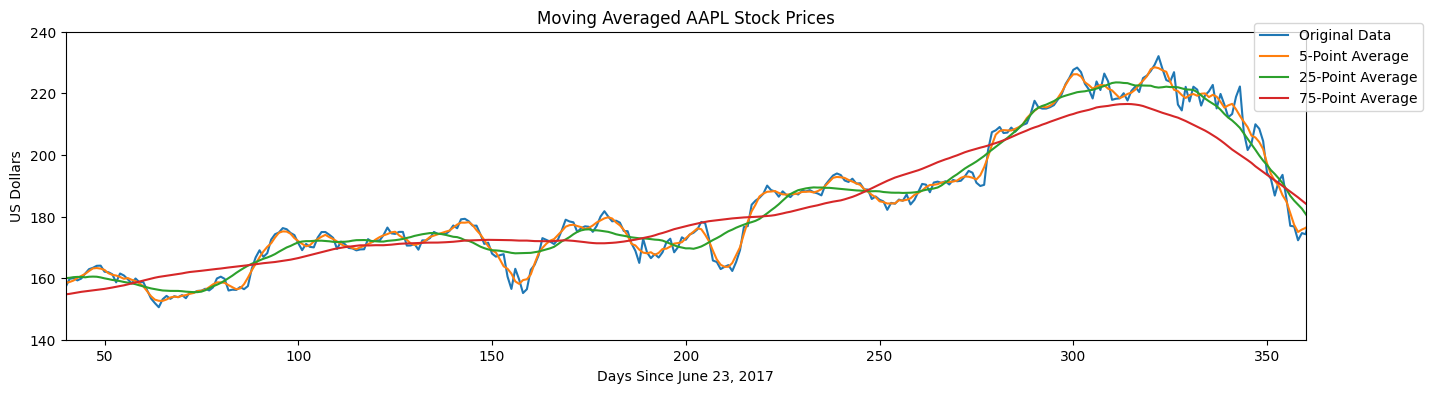

In [68]:
# Overlay stock prices
plt.figure(figsize=(16, 4))
plt.plot(np.arange(len(data)), data)
plt.plot(np.arange(len(data)), y5)
plt.plot(np.arange(len(data)), y25)
plt.plot(np.arange(len(data)), y75)

# Formatting mumbo jumbo to abstract away boundary issues
plt.xlim([40, 360])
plt.ylim([140, 240])
plt.legend(('Original Data', '5-Point Average', '25-Point Average', '75-Point Average'), bbox_to_anchor=(1.1, 1.05))
plt.ylabel("US Dollars")
plt.xlabel("Days Since June 23, 2017")
plt.title("Moving Averaged AAPL Stock Prices")
plt.show()

**Q:** As we use longer and longer moving average filters to process our signal (the stock data), does the filtered signal highlight longer term trends, or shorter term trends? Explain in 1-2 sentences.

<span style="color:blue">**A:** (TODO)  </span>
The stonk data is processed using longer moving average filters, which smooth out short-term volatility and noise to emphasize longer-term trends in the filtered signal. This happens as a result of the process of averaging over a greater number of points, which effectively reduces the influence of short-term fluctuations and highlights the underlying long-term patterns.

**Q:** Suppose that you had the closing price of Microsoft stock (MSFT) for every day it's existed, 1986 to present (~8000-10000 data points, one per day), and wanted to see how the company's stock price changed at the level of trends that occur over the course of a year using a moving average filter. How long of a moving average would you use? Why?

<span style="color:blue">**A:** (TODO) </span>

would apply a moving average filter that is 365 days long, or around 252 trading days, given that stonk markets are closed on weekends and holidays. Because it coincides with the annual cycle, this duration is ideal for taming shorter-term price fluctuations as it would smooth over long time thus reducing effects of short term fluctuations and help us depict long trends of stonk price

# Q2: The MACD Indicator

The Moving Average Convergence Divergence (MACD) Indicator is a trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price. In this question, we'll use the MACD indicator as a vehicle for introducing the exponential moving average as well as some more uses of signal processing in financial analysis.

## The Exponential Moving Average

To calculate the MACD of a stock, we first have to understand a new kind of moving average, called the *Exponential Moving Average* (EMA). What we did earlier is known as an Simple Moving Average (SMA) - all points are given equal weight. An EMA, on the other hand, places a greater weight, and therefore significance, on the most recent data points. The benefit of the EMA over the SMA is that the EMA reacts faster to recent price changes. 

### Derivation

Let's take a look at where the EMA comes from. We can express the EMA using the following recursive equation: 

$$y[n]=\alpha\cdot x[n] + (1-\alpha)\cdot y[n-1]$$

where $y[n]$ is the EMA at day $n$, and $x[n]$ is the stock price at day $n$. Now, why is this an "exponential" moving average? It might not be obvious when written it in this form. Let's write it out step by step to try to unravel the recursion. Assuming that $y[n]$ is zero $\forall n<0$,

$\begin{aligned}
    y[0] &= \alpha\cdot x[0] + (1-\alpha)\cdot y[-1] = \alpha\cdot x[0] \\
    y[1] &= \alpha\cdot x[1] + (1-\alpha)\cdot y[0] = \alpha\cdot x[1] + (1-\alpha)\cdot \alpha\cdot x[0] \\
    y[2] &= \alpha\cdot x[2] + (1-\alpha)\cdot y[1] = \alpha\cdot x[2] + (1-\alpha)\cdot (\alpha\cdot x[1] + (1-\alpha)\cdot \alpha\cdot x[0]) = \alpha\cdot x[2] + (1-\alpha)\cdot \alpha\cdot x[1] + (1-\alpha)^2\cdot \alpha\cdot x[0] \\
    &\vdots \\
    y[n] &= \alpha\sum_{k=0}^{n}(1-\alpha)^k\cdot x[n-k]
\end{aligned}$

Aha! Now that we have rewritten it, it's clear why we call this an EMA - we are weighting each previous data point with an value that decreases exponentially as we go further and further back in time.

### An LTI Perspective: The Impulse Response of an EMA Filter

We can apply a Kronecker delta to the EMA system by setting $x[n] = \delta[n]$ to find its impulse response:

$$h[n]=\alpha\sum_{k=0}^{n}(1-\alpha)^k\cdot \delta[n-k]= \alpha (1-\alpha)^n u[n]$$

which is just what we would expect: a (one-sided) decaying exponential!

## Your Job

Fill in the `ema_filter` function below to create and return the impulse response of an EMA filter truncated after `length` points. The value of $\alpha$ has been determined for you already. **Make sure you normalize the impulse response to sum to 1.**

In [69]:
def ema_filter(length):
    alpha = 2/(length+1)
    # TODO: Create and return an EMA filter with length "length"
    h = alpha * (-alpha + 1) ** np.arange(length)
    h = h/np.sum(h)
    return h

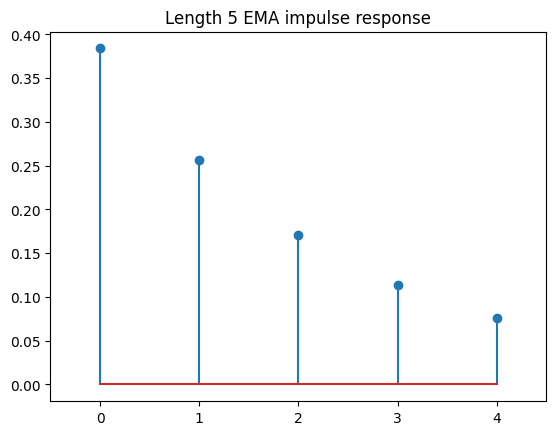

In [70]:
# Run me to plot!
h = ema_filter(5)
plt.figure()
plt.title("Length 5 EMA impulse response")
plt.xlim([-.5, 4.5])
plt.stem(h)
plt.show()

We can now convolve data with the impulse response to calculate the EMA! Note that if we flipped this signal (as we'd do in convolving) and slid it across some data signal, pointwise multiplying and summing to calculate our EMA, the strongest point would always be at the front, with an exponential drop-off as we go further and further back along the impulse response.

**2 Quick Things to Note:**

1. The LCCDE we originally gave describes an IIR filter, but we are using an FIR filter - after all, we can't store infinitely many values on a computer. In order to account for this, we truncate as is typically done, but we also renormalize so that the sum of the impulse response's coefficients, known as the DC gain, is 1.

2. The value for $\alpha$ that we have picked is motivated by reducing the output noise variance. We have a provided a reference below if you wish to read more about this.

## The MACD Line

The *MACD line* is calculated by taking the difference between the 26-day EMA of the stock and its 12-day EMA. In the cell below, we've defined an array of values, `data`, for you based on the same AAPL stock data we used earlier in this lab. In the cell below, calculate the MACD line. To do so,
- Create a length 26 EMA filter, $h_{26}$.
- Create a length 12 EMA filter, $h_{12}$.
- Calculate the 26-day EMA as $y_{26} = x * h_{26}$, where $x$ is `data`. **Use "valid" as the convolution mode** - we only want points where our signals fully overlap.
- Calculate the 12-day EMA as $y_{12} = x * h_{12}$. Again, use "valid" as the convolution mode.
- Crop $y_{12}$ by discarding its first 14 values, so that $y_{26}$ and $y_{12}$ have the same length. 
    - The first value in $y_{26}$ is an EMA taken over data points 1 through 26 (since the first point the signals fully overlap is at day 26), representing the exponential average at day 26, factoring in the previous 25 days. By cropping out the first 14 values of $y_{12}$, we ensure the first point in its output also corresponds to an EMA for day 26, but taken over the most recent 12 days rather than 26, essentially "aligning" the outputs.
- Compute the MACD line as $y_{12} - y_{26}$. **Store your result in a variable called `MACD`, as our plotting code uses this.**

After you finish, run the next cell to plot the results; here's the plot from the staff solution so you're able to check that your answer is correct before moving on:

<img src="macd.png" width="1100px" />

In [71]:
# Stock data
data = stock_prices[start:end]
# TODO calculate macd line
h_26 = ema_filter(26)
h_12 = ema_filter(12)
y_26 = np.convolve(data, h_26, mode= 'valid')
y_12 = np.convolve(data, h_12, mode= 'valid')
y_12_cropped = y_12[14:]
MACD = y_12_cropped - y_26


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


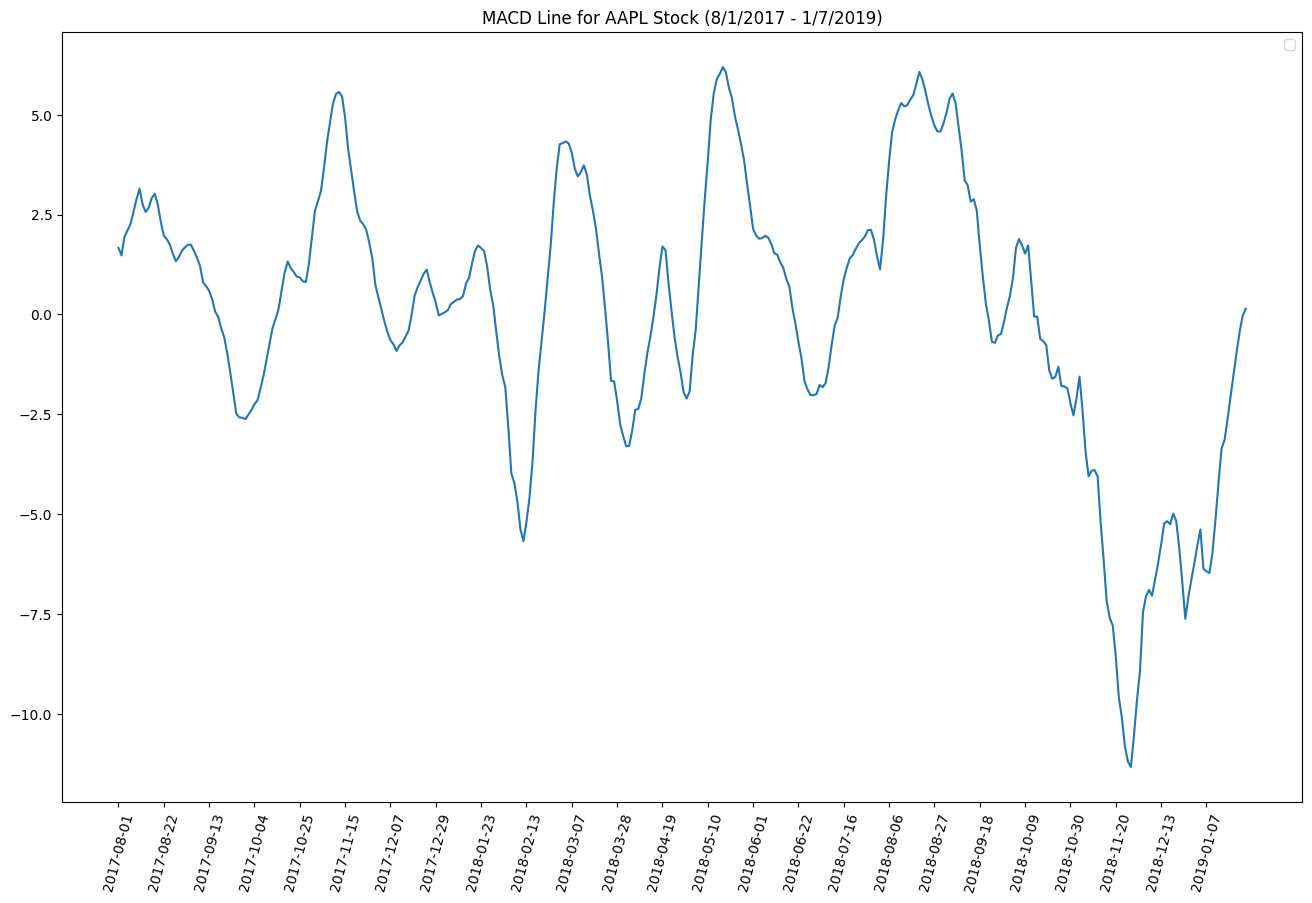

In [72]:
# Plotting Code
x = np.arange(len(MACD))
fig = plt.figure(figsize=(16, 10))
plt.xticks(x[::15], stock_dates[start+26:end:15], fontsize=10, rotation=75)
plt.plot(MACD)
plt.title("MACD Line for AAPL Stock (8/1/2017 - 1/7/2019)")
plt.legend()
plt.show()

## The Signal Line

Now that we have the MACD line, we want to take the 9-day EMA of the MACD line to create the *signal line*. Once equipped with the MACD line and the signal line, we can analyze the stock data. 

Add code in the top of the cell below to calculate the signal line by applying a 9-day EMA filter (use "same" as the convolution mode this time) to your MACD line, `MACD`, from above. Plotting code has been provided for you. **Store the result in a variable called `signal`, as this is what our plotting code uses.**

In [73]:
# TODO your signal line calculation here
h_9 = ema_filter(9)
signal = np.convolve(MACD, h_9, mode = 'same')


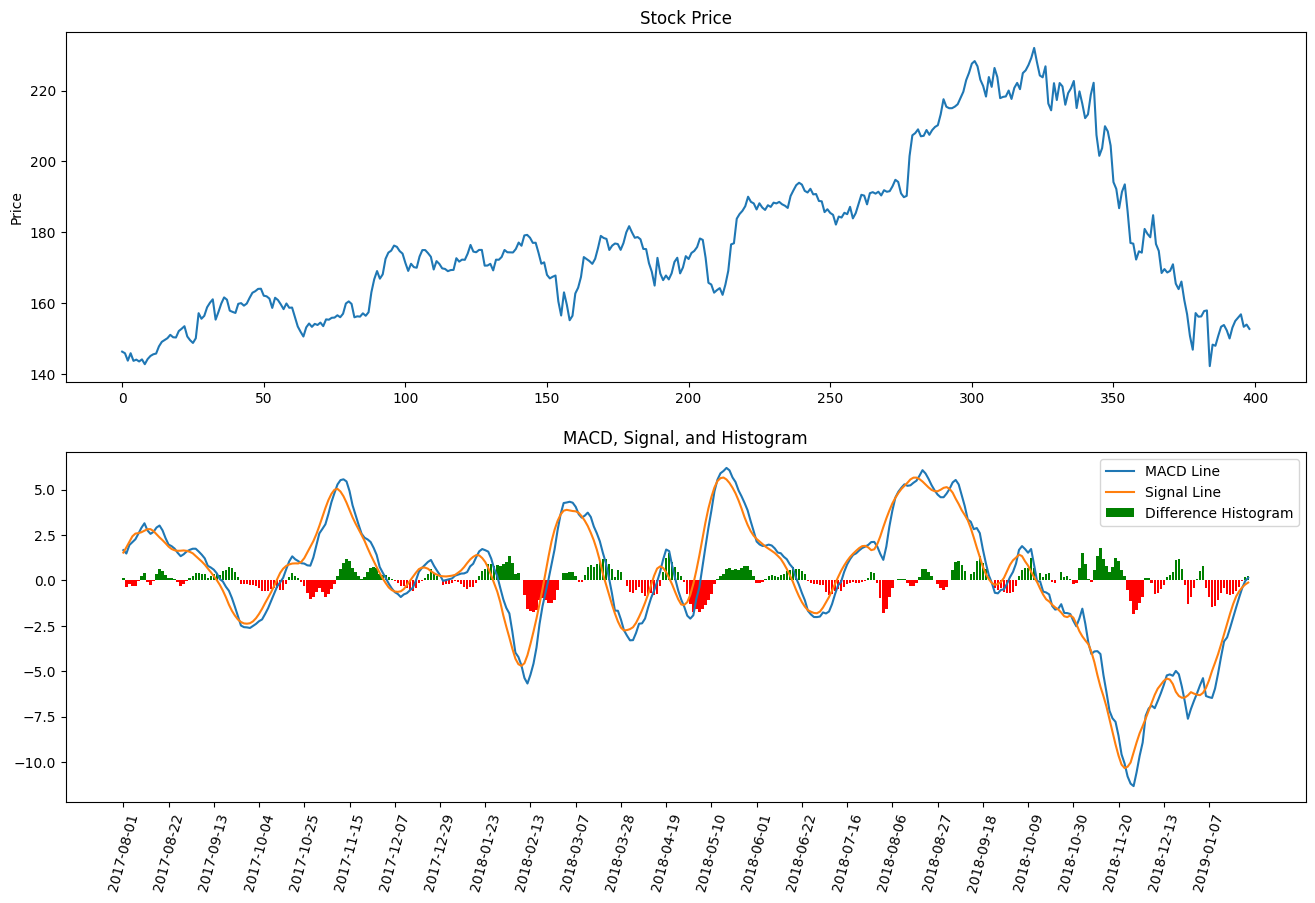

In [74]:
# Plotting Code
c = ['green', 'red']
colors = [c[bool(i)] for i in np.greater(signal, MACD)]
x = np.arange(len(signal))

plt.figure(figsize=(16,10))

plt.subplot(2,1,1)
plt.title("Stock Price")
plt.plot(data)
plt.ylabel("Price")

plt.subplot(2,1,2)
plt.title("MACD, Signal, and Histogram")
plt.xticks(x[::15], stock_dates[start+26:end:15], fontsize=10, rotation=75)
plt.plot(MACD, label='MACD Line')
plt.plot(signal, label='Signal Line')
plt.bar(range(len(signal)),(MACD-signal), color=colors, label="Difference Histogram")
plt.legend()
plt.show()

If done correctly, you should see that the signal line resembles a smoothed, shifted (slightly to the left) version of the MACD line, and the difference histogram is green where the MACD Line is above the signal line, and red where the signal line is above the MACD line.

## Interpretation of the MACD Indicator (from *Technical Analysis* [3])

In signal processing terms, the MACD is a filtered measure of velocity. The velocity has been passed through two first-order linear low-pass filters (the EMA filters). The signal line is that resulting velocity, filtered again. The difference between those two, the histogram, is a measure of the acceleration, with all three filters applied. A MACD crossover of the signal line indicates that the direction of the acceleration is changing. The MACD line crossing zero suggests that the average velocity is changing direction.

**Q:** Using this analogy of velocity and acceleration, we can think of a stock's price as a the position of the car. We know its velocity and acceleration from the MACD and histogram, respectively. What do points where the difference histogram is positive tell us about how the stock is behaving, and how can we use this inforamtion to decide whether or not to invest in a stock? How about when the difference histogram is negative?

<span style="color:blue">**A:** (TODO) </span>

The difference being that positive histogram indicating the acceleration much like a car speed up. Can be used as indicative to buy the stonk since it may be indication that prices will soar. We should not invest in stock that would likely decline because we will lose money. The negative declines is an indicative that the car is slowing down. 


# Q3 2D Edge Detection
We already implemented 1D Edge Detector in Lab1. Now we can try the 2D edge detection problem, on an image of your choice.

## Edge detection demo
This demo shows how a simple LTI system can be used to do rudiemtary edge detection

Prof Jon Tamir, EE 313 Spring 2020

In [75]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [76]:
# possible bug with PC and Google Colab: run this twice to get interactive plots
%matplotlib notebook
%matplotlib inline

## Load the image
Use the `plt.imread()` function to load your image into Python.
The image should be a color image, with R,G,B channels. 

You can either use any of your images or use the `cat.jpeg` image provided along with the Lab. Try to include your own pet image to see the results. 

(578, 639, 3)


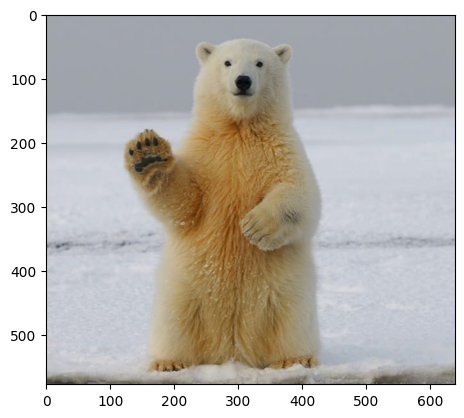

In [77]:
im_color = plt.imread('Bear.jpeg')
print(im_color.shape)
plt.figure()
plt.imshow(im_color)
plt.show()

## Combine the color channels
To make things simpler, let's consider the grayscale image instead, by taking the square-root sum-of-squares along the color (channel) dimension.

(578, 639)


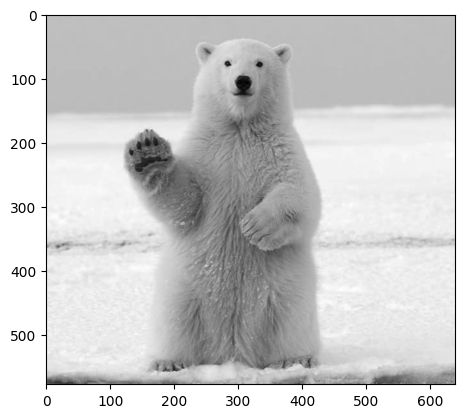

In [78]:
im = np.linalg.norm(im_color, axis=-1)
print(im.shape)
plt.figure()
plt.imshow(im, cmap='gray')
plt.show()

## Edge detector
The edge detector is studied in Lab2, and is a simple filter with two taps. For example, the impulse response of a 1D edge detector is defined as:

$$h[n] = \delta[n] - \delta[n - 1]$$
Implement a 1D dege detector `h` and plot using `plt.stem()`.

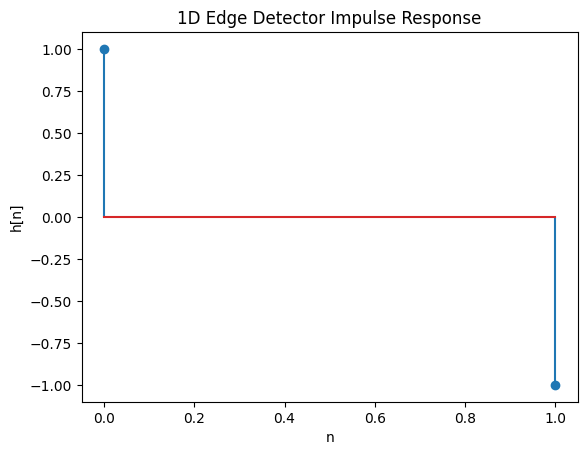

<Figure size 640x480 with 0 Axes>

In [79]:
# TODO: 1D edge detector and plot 

import numpy as np
import matplotlib.pyplot as plt

h = np.array([1,-1])
plt.stem(h)
plt.title("1D Edge Detector Impulse Response")
plt.ylabel("h[n]")
plt.xlabel("n")
plt.figure()
plt.show()

## Filter the image in the "up-down" direction
We will treat the image as a series of 1-D discete time signals. First, we will treat each column as a signal and filter it

In [80]:
y_ud = np.zeros((im.shape[0], im.shape[1]))
# TODO: filter each column

for i in range(im.shape[1]):
    convolved = np.convolve(im[:,i], h, 'same')
    y_ud[:,i] = convolved

We see edges in the vertical direction show up in our filtered output

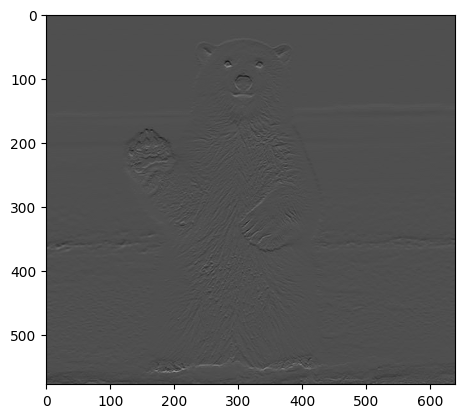

In [81]:
plt.figure()
plt.imshow(y_ud, cmap='gray')
plt.show()

## Filter the image in the "left-right" direction
Now let's treat each row as a 1-D signal

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# TODO filter each row
y_lr = np.zeros((im.shape[0], im.shape[1]))

for i in range(im.shape[0]):
    row_convolved = np.convolve(im[i,:], h, 'same')
    y_lr[i, :] = row_convolved

We see edges in the horizontal direction

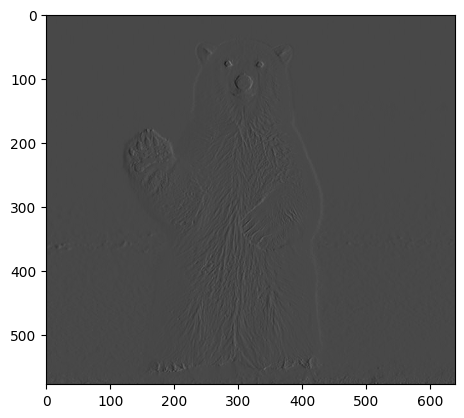

In [83]:
plt.figure()
plt.imshow(y_lr, cmap='gray')
plt.show()

## Combine the two outputs
Since the filter is linear, we can actually chain the two filters. But instead, we can do another square-root sum-of-squares of the two filtered outputs

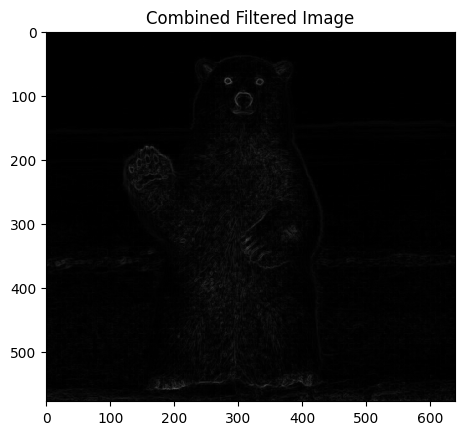

In [84]:
# TODO: combine two results and plot 
y_ud_exponent = y_ud ** 2
y_lr_exponent = y_lr ** 2
combined_output = np.sqrt(y_ud_exponent + y_lr_exponent)
plt.figure()
plt.imshow(combined_output, cmap ='gray')
plt.title("Combined Filtered Image")
plt.show()

## Threshold the result
We see the edges pop out in both directions. But the output is still an image (discrete-time signal), with arbitrary grayscale values. 

Let's try different thresholds on the result to "binarize" the image, where a larger threshold will reduce the amount of edges detected. Keep the one you like with clear edges. Choose the threshold to be a percentage of the maximum value in the image, e.g.  
`y_thresh = X * np.max(abs(y_filt)`, where `X` is a percentage, and `y_filt` is the filtered image

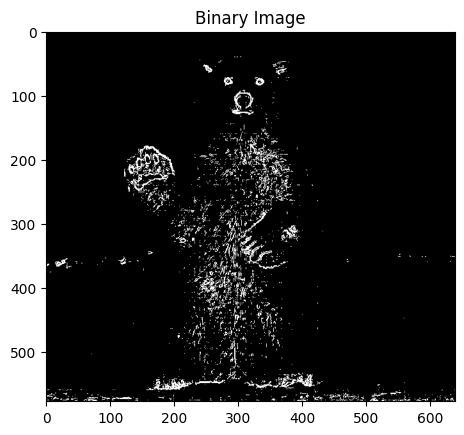

In [85]:
# TODO: threshold and plot
threshold_percentage = 6
threshold_value = threshold_percentage/100 * np.max(np.abs(combined_output))
binary_image = combined_output > threshold_value
plt.figure()
plt.imshow(binary_image, cmap= 'gray')
plt.title("Binary Image")
plt.show()

And there you have it! A simple edge detector.

There are **much** better, more complex ways of performing edge detection. One very popular approach is the **Canny Edge Detector**, named after John Canny:

https://en.wikipedia.org/wiki/Canny_edge_detector

# References
[1] Excerpt from an online signal processing textbook on the use of Moving Average Filters for noise reduction. [Link](https://www.analog.com/media/en/technical-documentation/dsp-book/dsp_book_Ch15.pdf)  
[2] Overview of the MACD indicator. [Link](https://www.investopedia.com/terms/m/macd.asp)  
[3] *Technical Analysis*. [Link](http://www.mrao.cam.ac.uk/~mph/Technical_Analysis.pdf)  
[4] Exponential Moving Average Resource. [Link](https://tttapa.github.io/Pages/Mathematics/Systems-and-Control-Theory/Digital-filters/Exponential%20Moving%20Average/Exponential-Moving-Average.html) \
[5] Generation of Sinusoidal Data. [Link](https://www.ft.unicamp.br/docentes/magic/khoros/html-dip/c2/s2/front-page.html)